# Setting up

In [1]:
%pylab

Using matplotlib backend: MacOSX
Populating the interactive namespace from numpy and matplotlib


In [2]:
%matplotlib inline

In [118]:
from scipy.sparse.linalg import eigs
from scipy.integrate import trapz, dblquad
from scipy.special import erf, erfc, xlogy
from scipy.constants import Boltzmann as kB, g as g_earth
from scipy.optimize import minimize_scalar

In [48]:
params = {
    "backend": "MacOSX",
    "font.family": "sans-serif",
    "text.usetex": True,
    "mathtext.fontset": "cm",
    "text.latex.preamble": "\n".join([
            r"\usepackage{amsmath}", r"\usepackage{lmodern}",
            r"\usepackage{siunitx}", r"\usepackage{units}",
            r"\usepackage{physics}", r"\usepackage{bm}",
            r"\usepackage{nicefrac}", r"\usepackage{amssymb}"
        ]),
    "figure.figsize": [6, 6],
    "lines.linewidth": 3.0,
    "lines.markersize": 5.0,
    "axes.spines.top": False,
    "axes.spines.right": False,
    "axes.labelsize": 28,
    "axes.formatter.limits": [-4, 4],
    "xtick.labelsize": 20,
    "ytick.labelsize": 20,
    "xtick.minor.visible": True,
    "ytick.minor.visible": True,
    "hist.bins": "auto",
    "errorbar.capsize": 5.0,
    }

matplotlib.rcParams.update(params)

In [80]:
set_printoptions(linewidth=400, formatter={"float_kind": lambda x: "%.5f" % x})

In [4]:
def N_distr(x, mu, sigma2):
    """Return the normal distribution with mean mu and variance sigma2."""
    return exp(-0.5*((x-mu)**2)/sigma2)/sqrt(2.0*pi*sigma2)

# Main text ($\sigma_{m} = 0$)

## Figure 3A

We outline below the computations to get the theoretical curve in Fig. 3A of our manuscript.

In [26]:
def compute_clean_T(xnpr, v, dg, dt):
    """Return the propagator (Eq. S22) for xnpr = x_{n^{+}}^{r}."""
    return (
        heaviside(-v[None, :], 0.0)*N_distr(
            xnpr[:, None], (v[None, :]+dg)*exp(-dt) - dg, 1.0-exp(-2.0*dt)
            )
        + heaviside(v[None, :], 0.0)*N_distr(
            xnpr[:, None], -dg - (v[None, :]-dg)*exp(-dt), 1.0-exp(-2.0*dt)
            )
        )*abs(xnpr[1]-xnpr[0])

In [27]:
def compute_clean_Ttilde(xnr, u, dg, dt):
    """Return the propagator (Eq. S23) for xnr = x_{n}^{r}."""
    return heaviside(-xnr[:, None], 0.0)*(
        N_distr(xnr[:, None], dg - (u[None, :]+dg)*exp(-dt), 1.0-exp(-2.0*dt))
        + N_distr(xnr[:, None], (u[None, :]+dg)*exp(-dt) - dg, 1.0-exp(-2.0*dt))
        )*abs(xnr[1]-xnr[0])

In [28]:
def find_clean_steady_states(out_grid, in_grid, dg, dt, TOL=1e-3):
    """Find and return the steady-state distributions for xnpr and xnr."""

    # compute transition matrices
    T_clean = compute_clean_T(out_grid, in_grid, dg, dt)
    Ttilde_clean = compute_clean_Ttilde(out_grid, in_grid, dg, dt)

    # find the 3 largest eigenvalues and associated eigenvectors
    p0 = N_distr(out_grid, 0.0, 1.0) # starting guess is standard Gaussian
    w_xnpr, v_xnpr = eigs(T_clean, k=3, v0=p0)
    w_xnr, v_xnr = eigs(Ttilde_clean, k=3, v0=p0)

    # find the eigenvector with eigenvalue 1
    p_xnpr = v_xnpr[:, where((w_xnpr - 1.0).__abs__() < TOL)[0][0]]
    p_xnr = v_xnr[:, where((w_xnr - 1.0).__abs__() < TOL)[0][0]]

    # re-normalize the eigenvectors to make them into distributions
    p_xnpr /= trapz(p_xnpr, out_grid)
    p_xnr /= trapz(p_xnr, out_grid)

    return p_xnpr.real, p_xnr.real

In [41]:
def compute_means(dg=0.8, nscan=40):
    """Run the calculation that gives you the steady-state
    average power as a function of sampling time."""

    # set up the grid over to discretize equations over
    grid_to = grid_from = linspace(-20.0, 20.0, 2000)
    times = logspace(-3.0, 2.0, nscan)
    mean_powers_out = zeros(int(nscan))
    
    for idx, time in enumerate(times):

        p_xnpr, p_xnr = find_clean_steady_states(grid_to, grid_from, dg, time)

        # compute the mean work
        mean_powers_out[idx] = dg*(trapz(grid_to*p_xnpr, grid_to) - trapz(grid_to*p_xnr, grid_to))/time
        
    return column_stack((times, mean_powers_out))

In [33]:
def get_clean_limits(times, dg=0.8):
    
    W_eq = sqrt(2.0/pi)*dg*exp(-0.5*(dg**2)) + (dg**2)*(erf(sqrt(0.5)*dg)-1.0)
    P_eq = W_eq/times
    
    P_infty = sqrt(2.0/pi)*dg*exp(-0.5*(dg**2))/(1+erf(sqrt(0.5)*dg))
    
    return P_eq, P_infty

Getting out the results for the parameters used in Fig. 3A

In [42]:
clean_results = compute_means()
quasistatic_limit, infty_limit = get_clean_limits(clean_results[:,0])

Given the results, we now re-plot the theory curve in Fig. 3A

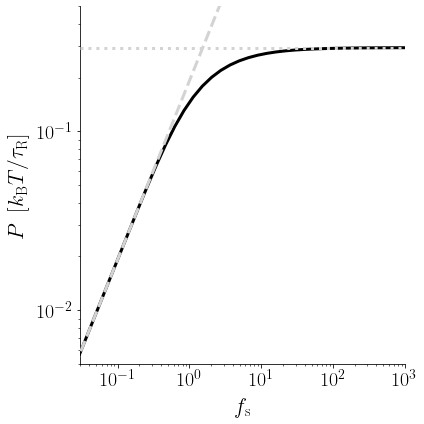

In [64]:
fig, ax = subplots(1, 1)

# plotting the results of numerical computation
ax.plot(1.0/clean_results[::-1,0], clean_results[::-1,1], "k", lw=3.0)

# plotting the theoretical asymptotic behaviors
ax.axhline(infty_limit, color="lightgray", ls=":", zorder=3)
ax.plot(1.0/clean_results[::-1, 0], quasistatic_limit[::-1], color="lightgray", ls="--", zorder=3)

# making the plot look nice
ax.set_yscale("log")
ax.set_ylim((5e-3, 0.5))
ax.set_xscale("log")
ax.set_xlim((3e-2, 1e3))
ax.set_ylabel(r"$P\ \left[k_{\mathrm{B}}T/\tau_{\mathrm{R}}\right]$", fontsize=22, labelpad=8)
ax.set_xlabel(r"$f_{\mathrm{s}}$", fontsize=22, labelpad=8)
ax.tick_params(labelsize=20)
fig.tight_layout()

We can also look at the velocity $v$ as a function of the sampling frequency $f_{\mathrm{s}}$; however, since $P$ and $v$ are related simply by a multiplicative factor of $\delta_{\mathrm{g}}$ then the curve will look qualitatively the same but will be shifted vertically from the $P$ vs. $f_{\mathrm{s}}$ (on a log-log scale) by an amount $-\log\delta_{\mathrm{g}}$.

## Figure 3B

Now we outline the calculations for Figure 3B:

In [71]:
def compute_pow_v_thresh(dg=0.8, nscan=40):
    
    """Compute the power vs. threshold curve by evaluating the mean first-passage time
    through the integral formula (Eq. 9)"""

    V = lambda x: (0.5*x + dg)*x # define the potential to be integrated

    theory_curve = zeros(nscan)
    threshold_values = linspace(1e-3, 3.0, theory_curve.size)
    for idx, Xt in enumerate(threshold_values):
        theory_curve[idx], _ = dblquad(
            lambda y, x: exp(V(x)-V(y)),
            -Xt, Xt,
            lambda x: -800.0, # setting to something really large and negative to replicate -\infty
            lambda x: x
        )
    
    mean_powers_out = dg*(2.0*(threshold_values)/theory_curve)
    
    return column_stack((threshold_values, mean_powers_out))

In [72]:
clean_results_thresh = compute_pow_v_thresh()

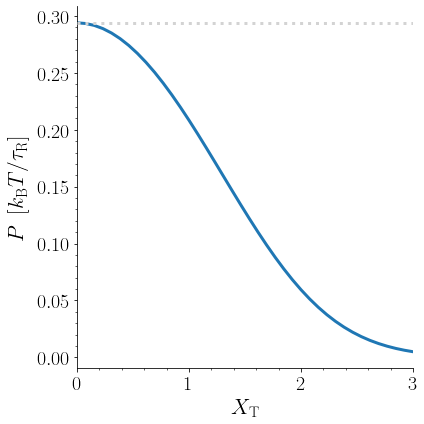

In [73]:
fig, ax = subplots(1, 1)

ax.plot(clean_results_thresh[:,0], clean_results_thresh[:,1], lw=3.0)

ax.axhline(infty_limit, color="lightgray", ls=":", zorder=3)
ax.axhline(0.0, color="lightgray", ls="--", zorder=3, lw=1.0)

ax.tick_params(labelsize=20)
ax.set_xticks([0.0, 1.0, 2.0, 3.0])
ax.set_xticklabels([r"$0$", r"$1$", r"$2$", r"$3$"])
ax.set_xlim((0.0, 2.5))


ax.set_ylabel(r"$P\ \left[k_{\mathrm{B}}T/\tau_{\mathrm{R}}\right]$", fontsize=22, labelpad=8)
ax.set_xlabel(r"$X_{\mathrm{T}}$", fontsize=22)
fig.tight_layout()

# Supplementary Material

Now we run through the computations that are outlined primarily in the Supplemental Material

## Section L

Here we run through the computations that generate Table S1.

In [87]:
def get_tbl_S1():
    # ============= DEFINE PROPERTIES ==============

    # define bead properties
    diameters = array([0.5, 1.5, 3.0, 5.0])*1e-6
    r = diameters*0.5 #radius
    mass = array([6.54e-17, 1.73e-15, 1.41e-14, 6.54e-14])
    gamma = array([4.20e-9, 1.25e-8, 2.52e-8, 4.19e-8])

    # define medium properties
    eta = 8.9e-4 # dynamic viscosity of water
    rho_f = 1e3 # density of water
    kT = kB*(293.0) # assume temperature of 20 degrees celcius
    beta = kT**(-1)

    # ============= COMPUTE QUANTITIES ==============

    # define S^{2} = tau_{f}/tau_{r} and Q^{2} = tau_{v}/tau_{r}
    Sval = 1.0
    Qval = 1.0

    # compute the fluid and velocity relaxation time scales
    tau_f = (r**2)*rho_f/eta
    tau_v = mass/gamma

    # compute critical kappa values for Q = Qval = 1 and S = Sval = 1
    kf = ((Sval**2)*gamma*eta)/((r**2)*rho_f)
    kv = ((Qval**2)*(gamma**2))/mass

    # compute delta values associated with kf and kv
    delta_s = mass*g_earth*sqrt(beta/kf)
    delta_q = mass*g_earth*sqrt(beta/kv)

    # compute velocity and power associated with critical kappa
    v_s = sqrt(2.0/pi)*exp(-0.5*(delta_s**2))*(1.0/sqrt(beta*kf)) / ((gamma/kf)*(1.0+erf(delta_s/sqrt(2.0))))
    pows_s = sqrt(2.0/pi)*delta_s*exp(-0.5*(delta_s**2)) / ((gamma/kf)*(1.0+erf(delta_s/sqrt(2.0))))
    
    # return in corresponding units to Table
    return vstack((diameters/1e-6, tau_f/1e-6, tau_v/1e-6, kf/1e-6, v_s/1e-6, pows_s))

In [88]:
get_tbl_S1()

array([[0.50000, 1.50000, 3.00000, 5.00000],
       [0.07022, 0.63202, 2.52809, 7.02247],
       [0.01557, 0.13840, 0.55952, 1.56086],
       [59808.00000, 19777.77778, 9968.00000, 5966.56000],
       [2954.82370, 570.08120, 197.57681, 84.03243],
       [468.46710, 2390.85145, 6753.43699, 13322.76756]])

## Section N ($\sigma_{m}\neq 0$)

In this section we work out the efficiency of our engine by considering the case where we have noisy measurements as modeled by a Gaussian noise kernel with mean zero and variance $\sigma_{\mathrm{m}}^{2}$ (ie. $p(y|x) = \mathcal{N}(y|x, \sigma_{\mathrm{m}}^{2})$)

Given this noise model the relative coordinates have new propagators. For detailed derivations of these propagators see associated Mathematica "propagators.nb" notebook.

In [135]:
def compute_noisy_T(xkpr, u, dg=0.8, sg=0.1, t=1e-3, alpha=2):
    """Return the propagator (Eq. S22) for xkpr = x_{n^{+}}^{r} but for noisy measurements."""
    return (
            (exp(t - (-dg + (-1 + alpha)*u[None,:] + exp(t)*(dg + xkpr[:,None]))**2/(2.*(-1 + exp(2*t) + (alpha**2)*(sg**2))))*(1 + erf(((-1 + exp(2*t) + alpha*(sg**2))*u[None,:] + alpha*(sg**2)*(dg - exp(t)*(dg + xkpr[:,None])))/(sqrt(2)*sg*sqrt((-1 + exp(2*t))*(-1 + exp(2*t) + (alpha**2)*(sg**2)))))))/(2.*sqrt(2*pi)*sqrt(-1 + exp(2*t) + (alpha**2)*(sg**2))) + 
            (exp(t/2. - ((dg + u[None,:] - exp(t)*(dg + xkpr[:,None]))**2/sinh(t))/(4.*exp(t)))*(1 - erf(u[None,:]/(sqrt(2)*sg))))/(4.*sqrt(pi)*sqrt(sinh(t)))
        )*abs(xkpr[1]-xkpr[0])

In [136]:
def compute_noisy_Ttilde(xkr, v, dg=0.8, sig=0.1, t=1e-3, alpha=2):
    """Return the propagator (Eq. S23) for xkr = x_{n}^{r} but for noisy measurements."""
    return (
        -(exp(t/2. - ((dg + v[None,:] - exp(t)*(dg + xkr[:,None]))**2/sinh(t))/(4.*exp(t)))*(-1 + erf(xkr[:,None]/(sqrt(2)*sig))))/(4.*sqrt(pi)*sqrt(sinh(t))) + 
        (exp((4*t - (2*xkr[:,None]**2)/((alpha**2)*(sig**2)) - ((dg - dg*exp(t) + v[None,:])**2/sinh(t))/exp(t) + ((1.0/sinh(t))*((alpha**2)*(sig**2)*(dg - dg*exp(t) + v[None,:]) - 2*(-1 + alpha)*xkr[:,None]*sinh(t))**2)/((alpha**2)*(sig**2)*((alpha**2)*(sig**2)*cosh(t) + (2 + alpha*(-4 + alpha*(2 + (sig**2))))*sinh(t))))/4.)*(-1 + (1.0/tanh(t)))*
        ((1.0/sinh(t))*(-2 + exp(2*t)*(1 + erf((-((alpha**2)*exp(t)*(sig**2)*(dg*(-1 + exp(t)) - v[None,:])) + (-1 + alpha)*(1 - exp(2*t))*xkr[:,None])/(sqrt(2)*alpha*sig*sqrt((-1 + exp(2*t))*(-(-1 + alpha)**2 + exp(2*t)*(1 + alpha*(-2 + alpha + alpha*(sig**2)))))))) + 
        erfc((exp(t)*((alpha**2)*(sig**2)*(dg - dg*exp(t) + v[None,:]) - 2*(-1 + alpha)*xkr[:,None]*sinh(t)))/(sqrt(2)*alpha*sig*sqrt((-1 + exp(2*t))*(-(-1 + alpha)**2 + exp(2*t)*(1 + alpha*(-2 + alpha + alpha*(sig**2)))))))) + 
        2*exp(t)*erf((abs((alpha**2)*exp(t)*(sig**2)*(dg*(-1 + exp(t)) - v[None,:]) + (-1 + alpha)*(-1 + exp(2*t))*xkr[:,None])*sqrt(2 + alpha*(-4 + alpha*(2 + (sig**2))) + (alpha**2)*(sig**2)*(1.0/tanh(t))))/(2.*alpha*sig*(-(-1 + alpha)**2 + exp(2*t)*(1 + alpha*(-2 + alpha + alpha*(sig**2))))))*
        sign((alpha**2)*exp(t)*(sig**2)*(dg*(-1 + exp(t)) - v[None,:]) + (-1 + alpha)*(-1 + exp(2*t))*xkr[:,None]) - 2*exp(t)*erf((abs(alpha*exp(t)*(sig**2)*(dg*(-1 + exp(t)) - v[None,:]) + xkr[:,None] - alpha*xkr[:,None] + exp(2*t)*(-1 + alpha + alpha*(sig**2))*xkr[:,None])*sqrt(2 + alpha*(-4 + alpha*(2 + (sig**2))) + (alpha**2)*(sig**2)*(1.0/tanh(t))))/
        (2.*exp(t)*((alpha**2)*exp(t)*(sig**3) + 2*(-1 + alpha)**2*sig*sinh(t))))*sign(alpha*exp(t)*(sig**2)*(dg*(-1 + exp(t)) - v[None,:]) + xkr[:,None] - alpha*xkr[:,None] + exp(2*t)*(-1 + alpha + alpha*(sig**2))*xkr[:,None]))*sinh(t))/(4.*sqrt(-2*(-1 + alpha)**2*pi + 2*exp(2*t)*pi*(1 + alpha*(-2 + alpha + alpha*(sig**2)))))
    )*abs(xkr[1]-xkr[0])

In [137]:
def find_noisy_steady_states(out_grid, in_grid, dg=0.8, sg=0.1, dt=1e-3, alpha=2.0, TOL=5e-3):
    """Find and return the steady-state distributions for xnpr and xnr given noisy measurements."""

    # compute transition matrices
    T = compute_noisy_T(out_grid, in_grid, dg, sg, dt, alpha)
    Ttilde = compute_noisy_Ttilde(out_grid, in_grid, dg, sg, dt, alpha)

    # find the 3 largest eigenvalues and associated eigenvectors
    p0 = N_distr(out_grid, 0.0, 1.0) # use equilibrium as a starting guess for iteration
    wT_ss, vT_ss = eigs(T, k=3, v0=p0)
    wTtilde_ss, vTtilde_ss = eigs(Ttilde, k=3, v0=p0)

    # find the eigenvector with eigenvalue 1
    p_xnpr = vT_ss[:, where((wT_ss - 1.0).__abs__() < TOL)[0][0]]
    p_xnr = vTtilde_ss[:, where((wTtilde_ss - 1.0).__abs__() < TOL)[0][0]]

    # re-normalize the eigenvectors to make them into distributions
    p_xnpr /= trapz(p_xnpr, out_grid)
    p_xnr /= trapz(p_xnr, out_grid)

    return p_xnpr.real, p_xnr.real

Given the steady-states we compute the input and output works...

In [138]:
def compute_thermo_quants(ngrid=4000, dg=0.8, sm=0.1, ts=1e-3, alpha=2, return_ss=False):
    """Compute the thermodynamic quantities of input and output work."""
    
    # ========== finding steady-state distributions ==========
    out_grid = in_grid = linspace(-60.0, 60.0, int(ngrid))
    p_xkpr, p_xkr = find_noisy_steady_states(out_grid, in_grid, dg, sm, ts, alpha)
    
    # regularization -- zero out entries that are sufficiently small and negative
    p_xkr[logical_and(p_xkr > -finfo("float32").eps, p_xkr < 0.0)] = 0.0
    p_xkpr[logical_and(p_xkpr > -finfo("float32").eps, p_xkpr < 0.0)] = 0.0
    
    # checks on distribution
    # will trigger error if there are big enough negative entries that are not 
    # captured by the regularization above
    assert (p_xkr >= 0.0).all(), "p_xkr has non-positive entries!"
    assert (p_xkpr >= 0.0).all(), "p_xkpr has non-positive entries!"
    
    p_xkr_norm = trapz(p_xkr, out_grid)
    p_xkpr_norm = trapz(p_xkpr, out_grid)
    
    if (abs(p_xkr_norm - 1.0) > (finfo("float32").eps)): 
        print(f"p_xkr not normalized! Normalization value {p_xkr_norm:.8f}")
    if (abs(p_xkpr_norm - 1.0) > (finfo("float32").eps)):
        print(f"p_xkpr not normalized! Normalization value {p_xkpr_norm:.8f}")
    
    # compute relevant moments
    ## first moments
    mu_xkpr = trapz(out_grid*p_xkpr, out_grid)
    mu_xkr = trapz(out_grid*p_xkr, out_grid)
    ## second moments
    ms_xkpr = trapz((out_grid**2)*p_xkpr, out_grid)
    ms_xkr = trapz((out_grid**2)*p_xkr, out_grid)
    
    W_in = 0.5*(ms_xkr-ms_xkpr)
    W_out = dg*(mu_xkpr-mu_xkr)
    
    if return_ss:
        return W_in, W_out, p_xkpr, p_xkr, out_grid
    else:
        return W_in

We compute the *information flow* using the steady-state relative coordinate distributions

In [144]:
def compute_info_flow(ngrid=4000, dg=0.8, sm=0.1, ts=1e-3, alpha=2, p_xkpr_in=None, p_xkr_in=None, inout_grid=None):
    
    # find steady-state distributions only if necessary
    if ((p_xkpr_in is None) or (p_xkr_in is None) or (inout_grid is None)):
        # define the grid of the solution
        out_grid = in_grid = linspace(-60.0, 60.0, int(ngrid))
        p_xkpr, p_xkr = find_noisy_steady_states(out_grid, in_grid, dg, sm, ts, alpha)
    else:
        p_xkpr = copy(p_xkpr_in)
        p_xkr = copy(p_xkr_in)
        out_grid = copy(inout_grid) 
    
    # regularization: zero out entries that are too small
    p_xkr[logical_and(p_xkr > -finfo("float32").eps, p_xkr < 0.0)] = 0.0
    p_xkpr[logical_and(p_xkpr > -finfo("float32").eps, p_xkpr < 0.0)] = 0.0
    
    # before proceeding to computations check that the distributions are behaving properly
    p_xkpr_norm = trapz(p_xkpr, out_grid)
    p_xkr_norm = trapz(p_xkr, out_grid)
    
    # bail if negative entries in probability distribution
    assert (p_xkpr >= 0.0).all(), "p_xkpr has non-positive entries!"
    assert (p_xkr >= 0.0).all(), "p_xkr has non-positive entries!"
    
    # complain if normalization is not sufficient to within single-float
    # but don't kill calculation
    if (abs(p_xkpr_norm - 1.0) > (finfo("float32").eps)):
        print(f"p_xkpr not normalized! Normalization value {p_xkpr_norm:.8f}")
    if (abs(p_xkr_norm - 1.0) > (finfo("float32").eps)): 
        print(f"p_xkr not normalized! Normalization value {p_xkr_norm:.8f}")
    
    # ========== computing entropies ==========
    
    # computing the conditional entropies
    H_xkr = -trapz(xlogy(p_xkr, p_xkr), out_grid)
    H_xkpr = -trapz(xlogy(p_xkpr, p_xkpr), out_grid)
    
    return H_xkpr - H_xkr

$\alpha = 2$ is now no longer correct since the trap is reacting to noisy measurements. Therefore, we do bisection to find $\alpha^{*}$, the value of $\alpha$ that makes the input work zero:

In [145]:
def optim(sm_in, ts_in, dg_in=0.8, ngrid_in=4000):
    
    def objective_func(alpha, dg, sm, ts, ngrid):
        win = compute_thermo_quants(ngrid=ngrid, dg=dg, sm=sm, ts=ts, alpha=alpha, return_ss=False)
        return abs(win)
    
    res = minimize_scalar(objective_func, bounds=(1e-2, 2.5), args=(dg_in, sm_in, ts_in, ngrid_in), method="bounded")
    
    return res.x

Putting all of this together we define a function that can compute the input and outpout work of our engine, as well as the information flow and the efficiency given experimental parameters:

In [148]:
def compute_noisy_efficiency(SNR=10.0, fs=180.0, dg=0.8, ngrid=10000):
    """Run the calculation that computes the efficiency for the experimental ratchet parameters."""
    
    sm = 1.0/SNR
    ts = 1.0/fs

    # find the alpha that makes the input work zero
    astar = optim(sm, ts, dg, ngrid_in=int(ngrid))
    
    # compute the quantities needed for the efficiency
    win, wout, p_xkpr, p_xkr, out_grid = compute_thermo_quants(
        ngrid=int(ngrid), dg=dg, sm=sm, ts=ts, alpha=astar, return_ss=True
        )
    inf_flow = compute_info_flow(
        ngrid=int(ngrid), dg=dg, sm=sm, ts=ts, alpha=astar, 
        p_xkpr_in=p_xkpr, p_xkr_in=p_xkr, inout_grid=out_grid
        )
    
    # compute the efficiency
    eta = wout/(win+inf_flow)
        
    return win, wout, inf_flow, eta

In [149]:
compute_noisy_efficiency()

(3.922963065505769e-10,
 0.001617662659954533,
 0.018906127151750773,
 0.08556287670152114)